## NLP-Movie-Review-Sentiment
### Modeling Notebook

Author: Qi Cai

Business Problem:




Stakeholders:
Movie 

Goals:
Our goal is to extract useful info from movie reviews to build machine learning models to correctly predict a review's sentiment being positive or negative.

In [9]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import string

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

In [2]:
# load dataset
df = pd.read_csv('./data/IMDB-Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
#binarizing emotion column
emotion_dict = {'negative': 0, 'positive': 1}
df['sentiment'] = df['sentiment'].map(emotion_dict)

## Start a Dummy Classifier

In [6]:
X = df.review # features
y = df.sentiment # target

# split the data to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [10]:
# Instantiate word tokenizer to later include in the pipeline
tokenizer = TweetTokenizer()

In [11]:
# Create a list of stopwords, based on the eda notebook.
stop_lst = stopwords.words('english') + list(string.punctuation) + ['I',"The",'film','like','movies', 'It', 'would','This','And','But','There','think', 'one','even', 'br',"'s",'film','films','movies', 'movie',"''", '``', "n't", "..."]
# included punctuations and product/company names

In [12]:
# Create a dummy pipeline 
dummy_pipe = Pipeline([('vectorizer', TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                        stop_words=stop_lst)), # NLP preprocessing: tokenize, remove stopwords, punctunations, lowercase
                     ('dumm', DummyClassifier(random_state=42))]) # first attempt: dummy classifier

dummy_pipe.fit(X_train, y_train)

/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fe4c461be50>>)),
                ('dumm', DummyClassifier(random_state=42))])

In [13]:
# predict target with dummy_pipe on testing set
y_pred = dummy_pipe.predict(X_test)
# print a classification report
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      1.00      0.66      6157
           1       0.00      0.00      0.00      6343

    accuracy                           0.49     12500
   macro avg       0.25      0.50      0.33     12500
weighted avg       0.24      0.49      0.33     12500



/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/echocai/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [14]:
accuracy_score(y_test, y_pred)

0.49256

In [15]:
# Check out confusion matrix
cm1 = confusion_matrix(y_test,y_pred)
cm1

array([[6157,    0],
       [6343,    0]])

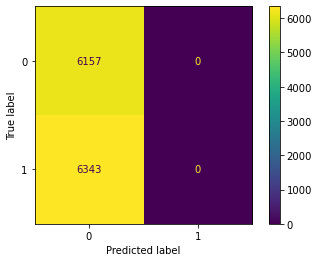

In [16]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp.plot()
plt.show()

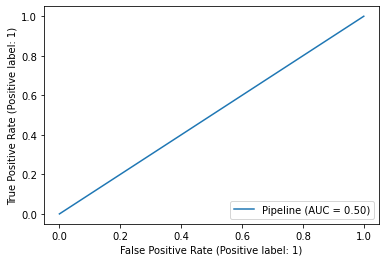

In [17]:
RocCurveDisplay.from_estimator( dummy_pipe, X_test, y_test )

The dummy classifier model performs with a 0.49 accuracy which aligns with the balanced class dataset. AUC score of 0.5. Will see how logistic regression perform with similar pipeline steps!

## Logistic Regression